# English-Spanish Translation: FNet
## Table of Contents
* Overview
* Configuration
* Setup
* Import datasets
* Model Development
* Transalation
* References

## Overview
In this Notebook, I will develop a English-Spanish Translation Model using FNet Transformer Encoder-Decoder Architecture from scratch.

## Configuration

In [2]:
class Config:
    vocab_size = 15000 # Vocabulary Size
    sequence_length = 20
    batch_size = 64
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    num_heads = 2
    epochs = 10 # Number of Epochs to train
    model_path = "model.h5"
    begin_token = "[start]"
    end_token = "[end]"
config = Config()

## Setup

Install latest version of TensorFlow if needed. 

In [3]:
# !pip install -q tensorflow==2.6.0

In [24]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pathlib
import random
import string
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os
import sklearn
from sklearn.model_selection import train_test_split

## Import datasets

In [5]:
data = pd.read_csv("/kaggle/input/englishspanish-translation-dataset/data.csv" if os.path.exists("/kaggle/input/englishspanish-translation-dataset/data.csv") else "data.csv")
data.head()

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [6]:
data["spanish"] = data["spanish"].apply(lambda item: config.begin_token + " " + item + " " + config.end_token)

In [7]:
data.head()

,english,spanish
0,Go.,[start] Ve. [end]
1,Go.,[start] Vete. [end]
2,Go.,[start] Vaya. [end]
3,Go.,[start] Váyase. [end]
4,Hi.,[start] Hola. [end]


In [8]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
print(strip_chars)
def spanish_standardize(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]"%re.escape(strip_chars), "")
english_vectorization = TextVectorization(
    max_tokens=config.vocab_size, 
    output_mode="int", 
    output_sequence_length=config.sequence_length,
)
spanish_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length + 1,
    standardize=spanish_standardize,
)
english_vectorization.adapt(list(data["english"]))
spanish_vectorization.adapt(list(data["spanish"]))

!"#$%&'()*+,-./:;<=>?@\^_`{|}~¿


In [9]:
def preprocess(english, spanish):
    return (english, spanish[:, :-1]), spanish[:, 1:]
def make_dataset(df, batch_size, mode):
    english = english_vectorization(list(df["english"]))
    spanish = spanish_vectorization(list(df["spanish"]))
    dataset = tf.data.Dataset.from_tensor_slices((english, spanish))
    if mode == "train":
       dataset = dataset.shuffle(256) 
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.take(len(df) // batch_size).cache().prefetch(16).repeat(1)
    return dataset

In [10]:
train, valid = train_test_split(data, test_size=config.validation_split)
train.shape, valid.shape

((101119, 2), (17845, 2))

In [11]:
train_ds = make_dataset(train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid, batch_size=config.batch_size, mode="valid")

In [12]:
for batch in train_ds.take(1):
    print(batch)

((<tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[   9,  265,  690, ...,    0,    0,    0],
       [  49,   40,    5, ...,    0,    0,    0],
       [ 181,    9,  175, ...,    0,    0,    0],
       ...,
       [   6,  550,   29, ...,    0,    0,    0],
       [ 275, 7139, 8730, ...,    0,    0,    0],
       [  26,   73,  258, ...,    0,    0,    0]])>, <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[  2,   6,  44, ...,   0,   0,   0],
       [  2,  90, 885, ...,   0,   0,   0],
       [  2, 144, 381, ...,   0,   0,   0],
       ...,
       [  2,   8,  15, ...,   0,   0,   0],
       [  2,  75,  62, ...,   0,   0,   0],
       [  2,  30, 395, ...,   0,   0,   0]])>), <tf.Tensor: shape=(64, 20), dtype=int64, numpy=
array([[    6,    44,    25, ...,     0,     0,     0],
       [   90,   885,    77, ...,     0,     0,     0],
       [  144,   381,     6, ...,     0,     0,     0],
       ...,
       [    8,    15,   774, ...,     0,     0,     0],
       [   75,    62, 1

## Model Development

### The FNet Encoder

In [13]:
class FNetEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, **kwargs):
        super(FNetEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs):
        # Casting the inputs to complex64
        inp_complex = tf.cast(inputs, tf.complex64)
        # Projecting the inputs to the frequency domain using FFT2D and
        # extracting the real part of the output
        fft = tf.math.real(tf.signal.fft2d(inp_complex))
        proj_input = self.layernorm_1(inputs + fft)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

### Positional Embedding

In [14]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


### FNet Decoder

In [15]:
class FNetDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(FNetDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True
        
    def call(self, inputs, encoder_outputs, mask = None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask != None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        
        attention_output_1 = self.attention_1(
            query=inputs, 
            value=inputs, 
            key=inputs, 
            attention_mask=causal_mask
        )
        
        out_1 = self.layernorm_1(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query=out_1, 
            value=encoder_outputs, 
            key=encoder_outputs, 
            attention_mask=padding_mask
        )
        
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        
        proj_output = self.dense_proj(out_2)
        
        return self.layernorm_3(out_2 + proj_output)
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

### The FNet Model

In [16]:
def get_fnet(config):
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(encoder_inputs)
    encoder_outputs = FNetEncoder(config.embed_dim, config.latent_dim)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, config.embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(decoder_inputs)
    x = FNetDecoder(config.embed_dim, config.latent_dim, config.num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(config.vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="outputs")

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    fnet = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="fnet"
    )
    return fnet

In [17]:
fnet = get_fnet(config)

In [18]:
fnet.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 256)    3845120     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
f_net_encoder (FNetEncoder)     (None, None, 256)    132608      positional_embedding[0][0]       
________________________________________________________________________________________

Let's visualize the Model.

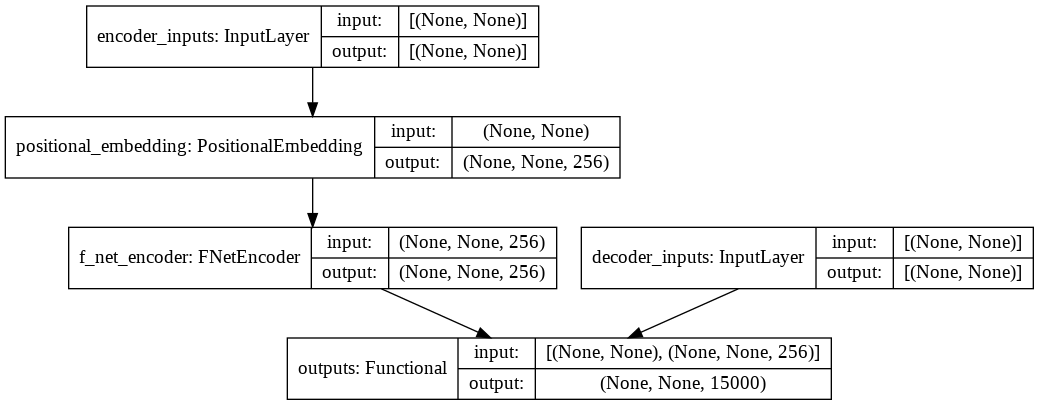

In [19]:
keras.utils.plot_model(fnet, show_shapes=True)

### Model Training


In [20]:
fnet.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(config.model_path, save_weights_only=True, save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=5, min_delta=1e-4, min_lr=1e-4)
if os.path.exists(config.model_path):
  fnet.load_weights(config.model_path)
fnet.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoint, reduce_lr])

Epoch 1/10
1579/1579 [==============================] - 108s 68ms/step - loss: 0.4158 - accuracy: 0.7648 - val_loss: 0.6592 - val_accuracy: 0.6952
Epoch 2/10
1579/1579 [==============================] - ETA: 0s - loss: 0.3765 - accuracy: 0.7840

## Translation


In [22]:
spanish_vocab = spanish_vectorization.get_vocabulary()
spanish_index_lookup = dict(zip(range(len(spanish_vocab)), spanish_vocab))
def decode_sequence(fnet, input_sentence):
    tokenized_input_sentence = english_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(config.sequence_length):
        tokenized_target_sentence = spanish_vectorization([decoded_sentence])[:, :-1]
        predictions = fnet([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spanish_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [23]:
fnet.load_weights(config.model_path)
for i in np.random.choice(len(data), 10):
    item = data.iloc[i]
    translated = decode_sequence(fnet, item["english"])
    print("English:", item["english"])
    print("Spanish:", item["spanish"])
    print("Translated:", translated)

English: She walked as fast as she could to catch up with him.
Spanish: [start] Ella caminó tan rápido como pudo para alcanzarlo. [end]
Translated: [start] ella caminó tan rápido como pudo para llegar a la orden [end]
English: Tom doesn't listen to advice.
Spanish: [start] Tom no escucha consejos. [end]
Translated: [start] tom no escucha consejo [end]
English: What's the emergency?
Spanish: [start] ¿Cuál es la emergencia? [end]
Translated: [start] cuál es la emergencia [end]
English: We have made numerous improvements to our house since we bought it.
Spanish: [start] Hemos hecho varias mejoras a nuestra casa desde que la compramos. [end]
Translated: [start] hemos hecho numerosas mejoras en nuestra casa desde que lo hice [end]
English: I neither drink nor smoke.
Spanish: [start] Yo no tomo ni fumo. [end]
Translated: [start] no bebo ni fumo [end]
English: Grandmother mows the grass in the garden.
Spanish: [start] La abuela corta el césped en el jardín. [end]
Translated: [start] el abuela

## References
- [FNet: Mixing Tokens with Fourier Transforms](https://arxiv.org/abs/2105.03824v3)
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762v5)
- [Text Generation using FNet](https://keras.io/examples/nlp/text_generation_fnet/)
